# Labeled Faces in the Wild 

## Imports

In [1]:
import sys 
import os
import numpy as np 
import matplotlib.pyplot as plt
from skimage import io


import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import Dataset

sys.path.insert(0, '../../Utils')

import models
from train import *
from metrics import *  
from data_downloaders import *

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## Hyperparameters

In [2]:
n_epochs = 50
batch_size = 8
lr = 0.001
k = 3


## Load Labeled Faces in the Wild 
### http://vis-www.cs.umass.edu/lfw/

LFW successfully downloaded and preprocessed.


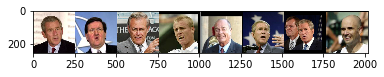

In [3]:
get_lfw('../../Datasets/')


data_dir = "../../Datasets/lfw/lfw_20/"

img_paths = []
for p in os.listdir(data_dir): 
    for i in os.listdir(os.path.join(data_dir,p)): 
        img_paths.append(os.path.join(data_dir,p,i))
        
people = []
people_to_idx = {}
k = 0 
for i in img_paths: 
    name = i.split('/')[-2]
    if name not in people_to_idx: 
        people.append(name)
        people_to_idx[name] = k
        k += 1


img_paths = np.random.permutation(img_paths)

lfw_size = len(img_paths)

lfw_train_size = int(0.8 * lfw_size)

lfw_train_list = img_paths[:lfw_train_size]
lfw_test_list = img_paths[lfw_train_size:]

class LFWDataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform
        
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    def __getitem__(self, idx): 
        img_path = self.file_list[idx]
        image = io.imread(img_path)
        label = self.people_to_idx[img_path.split('/')[-2]]
        
        if self.transform is not None: 
            image = self.transform(image)
        
        return image, label
        

# Data augmentation 
train_transform = torchvision.transforms.Compose([
    #torchvision.transforms.RandomRotation(10),
    #torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
 
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    

trainset = LFWDataset(lfw_train_list, people_to_idx, transform=train_transform)
testset = LFWDataset(lfw_test_list, people_to_idx, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

## Train Model 

In [4]:
net = models.tiny_cnn(n_in=3, n_out=200, n_hidden=32, size=250).to(device)

net.apply(models.weights_init)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [ ]:
train(net, trainloader, testloader, optimizer, loss, n_epochs, verbose=True)